## Swin UNETR Model

The inputs to [Swin UNETR](https://arxiv.org/pdf/2201.01266.pdf) are 3D multi-modal MRI images with 4 channels.
The patch partition block creates non-overlapping patches of the input data and projects them into embedding tokens with a resolution of 128x128x128.
The projected tokens are then encoded by using a 3D [Swin Transformer](https://openaccess.thecvf.com/content/ICCV2021/papers/Liu_Swin_Transformer_Hierarchical_Vision_Transformer_Using_Shifted_Windows_ICCV_2021_paper.pdf) in which the self-attention is computed within local windows.
The interaction between different windows is obtained by using 3D window shifting as illustrated below.

![image](https://github.com/Project-MONAI/tutorials/blob/main/figures/shift_patch.png?raw=1)

The transformer-based encoder is connected to a CNN-decoder via skip connection at multiple resolutions.
The segmentation output consists of 3 output channels corresponding to ET, WT, and TC sub-regions and is computed by using a 1x1x1 convolutional layer followed by Sigmoid activation function.


 ## Download from google drive & create json file



In [ ]:
!gdown 1VFZDI21HXbVQRJOawGxAiQZxFERysLC4 -O datasets.zip

!unzip ./datasets.zip

In [3]:
import os
import json

# Set the path to data directory
data_dir = "./BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

base_dir = "MICCAI_BraTS2020_TrainingData/"
# Get a list of all directories in the data directory
all_dirs = os.listdir(data_dir)

# Create a list of all file paths by joining data directory and directory names
all_paths = [os.path.join(data_dir, d) for d in all_dirs]

# Calculate sizes for training, validation, and test sets
size = len(all_paths)
train_size = int(0.7 * size)
val_size = int(0.1 * size)

# Split the file paths into training, validation, and test sets
train_files = all_paths[:train_size]
val_files = all_paths[train_size:train_size + val_size]
test_files = all_paths[train_size + val_size:]

# Function to extract ID from file path
def extract_id_from_path(file_path):
    return file_path.split("/")[-1]

# Create a list for training samples
training_samples = []
for file_path in train_files:
    id = extract_id_from_path(file_path)
    if "csv" in id:
      continue
    sample = {
        "fold": 0,  # Set fold to 0 to indicate it's in the training set
        "image": [
            os.path.join(base_dir, f"{id}/{id}_flair.nii"),
            os.path.join(base_dir, f"{id}/{id}_t1ce.nii"),
            os.path.join(base_dir, f"{id}/{id}_t1.nii"),
            os.path.join(base_dir, f"{id}/{id}_t2.nii")
        ],
        "label": os.path.join(base_dir, f"{id}/{id}_seg.nii")
    }
    training_samples.append(sample)

# Create a list for validation samples
validation_samples = []
for file_path in val_files:
    id = extract_id_from_path(file_path)
    if "csv" in id:
      continue
    sample = {
        "fold": 1,  # Set fold to 1 to indicate it's in the validation set
        "image": [
            os.path.join(base_dir, f"{id}/{id}_flair.nii"),
            os.path.join(base_dir, f"{id}/{id}_t1ce.nii"),
            os.path.join(base_dir, f"{id}/{id}_t1.nii"),
            os.path.join(base_dir, f"{id}/{id}_t2.nii")
        ],
        "label": os.path.join(base_dir, f"{id}/{id}_seg.nii")
    }
    validation_samples.append(sample)

# Create a list for test samples
test_samples = []
for file_path in test_files:
    id = extract_id_from_path(file_path)
    if "csv" in id:
      continue
    sample = {
        "fold": 2,  # Set fold to 2 to indicate it's in the test set
        "image": [
            os.path.join(base_dir, f"{id}/{id}_flair.nii"),
            os.path.join(base_dir, f"{id}/{id}_t1ce.nii"),
            os.path.join(base_dir, f"{id}/{id}_t1.nii"),
            os.path.join(base_dir, f"{id}/{id}_t2.nii")
        ],
        "label": os.path.join(base_dir, f"{id}/{id}_seg.nii")
    }
    test_samples.append(sample)

# Combine all samples into one list
all_samples = training_samples + validation_samples + test_samples

# Create JSON data structure
all_data = {"training": all_samples}

# Convert the dictionary to a JSON string
json_data = json.dumps(all_data, indent=4)

# Write the JSON string to a file
with open('brats20_folds.json', 'w') as json_file:
    json_file.write(json_data)


## Setup environment

In [6]:
!pip install -r requirements.txt

  Cloning https://github.com/Project-MONAI/MONAI.git (to revision 07de215c) to /tmp/pip-req-build-kfthw4ns
  Running command git clone --filter=blob:none --quiet https://github.com/Project-MONAI/MONAI.git /tmp/pip-req-build-kfthw4ns
  Running command git checkout -q 07de215c
  Resolved https://github.com/Project-MONAI/MONAI.git to commit 07de215c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.1/74.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.8/308.8 kB 28.0 MB/s eta 0:00:00
  Created wheel for monai: filename=monai-0.8.1+271.g07de215c-py3-none-any.whl size=837952 sha256=0f7cab7c3743bc2e2610887900b855eaff604b78f51144aa1fd96fb14a0017f4
  Stored in directory: /tmp/pip-ephem-wheel-cache-ckx9_znv/wheels/ac/99/be/f56163cfe0e9745f1b5c1ec63737532c7e0e

In [7]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

2023-12-04 12:41:40.168993: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-04 12:41:40.169088: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-04 12:41:40.169172: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-04 12:41:44.160090: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Setup imports

In [8]:
import os
import json
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR
from monai import data
from monai.data import decollate_batch
from functools import partial

import torch


print_config()

MONAI version: 0.8.1+271.g07de215c
Numpy version: 1.23.5
Pytorch version: 2.1.0+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 07de215caf79dabec20ac53fb38d9f2df36f182a
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.1.1
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.14.1
gdown version: 4.6.6
TorchVision version: 0.16.0+cu118
tqdm version: 4.59.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.5.3
einops version: 0.4.1
transformers version: 4.35.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [9]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpdjv_sh9t


## Setup average meter, fold reader, checkpoint saver

In [10]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = np.where(self.count > 0, self.sum / self.count, self.sum)

# Add test data
def datafold_read(datalist, basedir, fold=0, key="training"):
    with open(datalist) as f:
        json_data = json.load(f)

    json_data = json_data[key]

    for d in json_data:
        for k in d:
            if isinstance(d[k], list):
                d[k] = [os.path.join(basedir, iv) for iv in d[k]]
                #print([os.path.join(basedir, iv) for iv in d[k]])
            elif isinstance(d[k], str):
                d[k] = os.path.join(basedir, d[k]) if len(d[k]) > 0 else d[k]

    tr = []
    val = []
    test = []
    for d in json_data:
        if "fold" in d and d["fold"] == fold:
            val.append(d)
        elif "fold" in d and d["fold"] == 2:
            test.append(d)
        else:
            tr.append(d)

    return tr, val, test


def save_checkpoint(model, epoch, filename="model.pt", best_acc=0, dir_add=root_dir):
    state_dict = model.state_dict()
    save_dict = {"epoch": epoch, "best_acc": best_acc, "state_dict": state_dict}
    filename = os.path.join(dir_add, filename)
    torch.save(save_dict, filename)
    print("Saving checkpoint", filename)

## Setup dataloader

In [11]:
# Add test dataloader
def get_loader(batch_size, data_dir, json_list, fold, roi):
    data_dir = data_dir
    datalist_json = json_list
    train_files, validation_files, test_files = datafold_read(datalist=datalist_json, basedir=data_dir, fold=fold)
    print(len(train_files), len(validation_files), len(test_files))
    train_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            transforms.CropForegroundd(
                keys=["image", "label"],
                source_key="image",
                k_divisible=[roi[0], roi[1], roi[2]],
            ),
            transforms.RandSpatialCropd(
                keys=["image", "label"],
                roi_size=[roi[0], roi[1], roi[2]],
                random_size=False,
            ),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
            transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
            transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
            transforms.RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
            transforms.RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        ]
    )
    val_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ]
    )

    train_ds = data.Dataset(data=train_files, transform=train_transform)

    train_loader = data.DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=8,
        pin_memory=True,
    )
    val_ds = data.Dataset(data=validation_files, transform=val_transform)
    val_loader = data.DataLoader(
        val_ds,
        batch_size=1,
        shuffle=False,
        num_workers=8,
        pin_memory=True,
    )

    test_ds = data.Dataset(data=test_files, transform=val_transform)
    test_loader = data.DataLoader(
        test_ds,
        batch_size=1,
        shuffle=False,
        num_workers=8,
        pin_memory=True,
    )
    print(len(train_loader), len(val_loader), len(test_loader))
    return train_loader, val_loader, test_loader

## Set dataset root directory and hyper-parameters

The following hyper-parameters are set for the purpose of this tutorial. However, additional changes, as described below, maybe beneficial.

If GPU memory is not sufficient, reduce sw_batch_size to 2 or batch_size to 1.

Decrease val_every (validation frequency) to 1 for obtaining more accurate checkpoints.

In [12]:
data_dir = "./BraTS2020_TrainingData"
json_list = "./brats20_folds.json"
roi = (128, 128, 128)
batch_size = 2
sw_batch_size = 4
fold = 1
infer_overlap = 0.5
max_epochs = 100
val_every = 10
train_loader, val_loader, test_loader = get_loader(batch_size, data_dir, json_list, fold, roi)

257 37 75
129 37 75


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Check data shape and visualize

image shape: (240, 240, 155), label shape: (240, 240, 155)


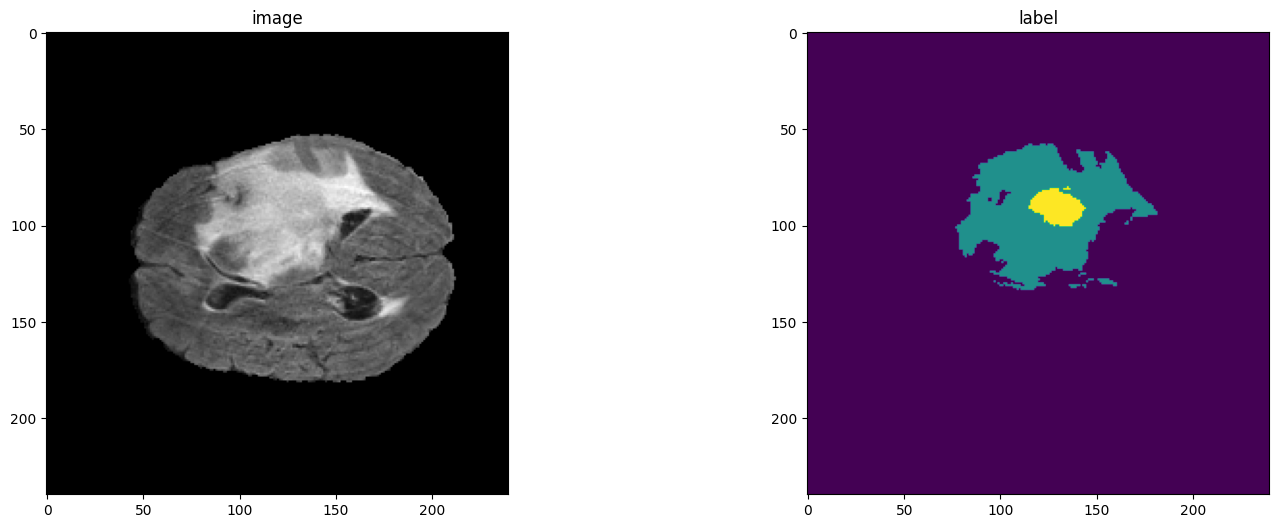

In [13]:
img_add = os.path.join(data_dir, "MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii")
label_add = os.path.join(data_dir, "MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii")
img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()
print(f"image shape: {img.shape}, label shape: {label.shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[:, :, 78], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 78])
plt.show()

## Create Swin UNETR model

In this scetion, we create Swin UNETR model for the 3-class brain tumor semantic segmentation. We use a feature size of 48. We also use gradient checkpointing (use_checkpoint) for more memory-efficient training. However, use_checkpoint for faster training if enough GPU memory is available.  

In [14]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=roi,
    in_channels=4,
    out_channels=3,
    feature_size=48,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    use_checkpoint=True,
).to(device)

## Optimizer and loss function

In [15]:
torch.backends.cudnn.benchmark = True
dice_loss = DiceLoss(to_onehot_y=False, sigmoid=True)
post_sigmoid = Activations(sigmoid=True)
post_pred = AsDiscrete(argmax=False, threshold=0.5)
dice_acc = DiceMetric(include_background=True, reduction=MetricReduction.MEAN_BATCH, get_not_nans=True)
model_inferer = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=sw_batch_size,
    predictor=model,
    overlap=infer_overlap,
)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

## Define Train and Validation Epoch

In [16]:
def train_epoch(model, loader, optimizer, epoch, loss_func):
    model.train()
    start_time = time.time()
    run_loss = AverageMeter()
    for idx, batch_data in enumerate(loader):
        data, target = batch_data["image"].to(device), batch_data["label"].to(device)
        logits = model(data)
        loss = loss_func(logits, target)
        loss.backward()
        optimizer.step()
        run_loss.update(loss.item(), n=batch_size)
        print(
            "Epoch {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
            "loss: {:.4f}".format(run_loss.avg),
            "time {:.2f}s".format(time.time() - start_time),
        )
        start_time = time.time()
    return run_loss.avg


def val_epoch(
    model,
    loader,
    epoch,
    acc_func,
    model_inferer=None,
    post_sigmoid=None,
    post_pred=None,
):
    model.eval()
    start_time = time.time()
    run_acc = AverageMeter()

    with torch.no_grad():
        for idx, batch_data in enumerate(loader):
            data, target = batch_data["image"].to(device), batch_data["label"].to(device)
            logits = model_inferer(data)
            val_labels_list = decollate_batch(target)
            val_outputs_list = decollate_batch(logits)
            val_output_convert = [post_pred(post_sigmoid(val_pred_tensor)) for val_pred_tensor in val_outputs_list]
            acc_func.reset()
            acc_func(y_pred=val_output_convert, y=val_labels_list)
            acc, not_nans = acc_func.aggregate()
            run_acc.update(acc.cpu().numpy(), n=not_nans.cpu().numpy())
            dice_tc = run_acc.avg[0]
            dice_wt = run_acc.avg[1]
            dice_et = run_acc.avg[2]
            print(
                "Val {}/{} {}/{}".format(epoch, max_epochs, idx, len(loader)),
                ", dice_tc:",
                dice_tc,
                ", dice_wt:",
                dice_wt,
                ", dice_et:",
                dice_et,
                ", time {:.2f}s".format(time.time() - start_time),
            )
            start_time = time.time()

    return run_acc.avg

## Define Trainer

In [17]:
def trainer(
    model,
    train_loader,
    val_loader,
    optimizer,
    loss_func,
    acc_func,
    scheduler,
    model_inferer=None,
    start_epoch=0,
    post_sigmoid=None,
    post_pred=None,
):
    val_acc_max = 0.0
    dices_tc = []
    dices_wt = []
    dices_et = []
    dices_avg = []
    loss_epochs = []
    trains_epoch = []
    for epoch in range(start_epoch, max_epochs):
        print(time.ctime(), "Epoch:", epoch)
        epoch_time = time.time()
        train_loss = train_epoch(
            model,
            train_loader,
            optimizer,
            epoch=epoch,
            loss_func=loss_func,
        )
        print(
            "Final training  {}/{}".format(epoch, max_epochs - 1),
            "loss: {:.4f}".format(train_loss),
            "time {:.2f}s".format(time.time() - epoch_time),
        )

        if (epoch + 1) % val_every == 0 or epoch == 0:
            loss_epochs.append(train_loss)
            trains_epoch.append(int(epoch))
            epoch_time = time.time()
            val_acc = val_epoch(
                model,
                val_loader,
                epoch=epoch,
                acc_func=acc_func,
                model_inferer=model_inferer,
                post_sigmoid=post_sigmoid,
                post_pred=post_pred,
            )
            dice_tc = val_acc[0]
            dice_wt = val_acc[1]
            dice_et = val_acc[2]
            val_avg_acc = np.mean(val_acc)
            print(
                "Final validation stats {}/{}".format(epoch, max_epochs - 1),
                ", dice_tc:",
                dice_tc,
                ", dice_wt:",
                dice_wt,
                ", dice_et:",
                dice_et,
                ", Dice_Avg:",
                val_avg_acc,
                ", time {:.2f}s".format(time.time() - epoch_time),
            )
            dices_tc.append(dice_tc)
            dices_wt.append(dice_wt)
            dices_et.append(dice_et)
            dices_avg.append(val_avg_acc)
            if val_avg_acc > val_acc_max:
                print("new best ({:.6f} --> {:.6f}). ".format(val_acc_max, val_avg_acc))
                val_acc_max = val_avg_acc
                save_checkpoint(
                    model,
                    epoch,
                    best_acc=val_acc_max,
                )
            scheduler.step()
    print("Training Finished !, Best Accuracy: ", val_acc_max)
    return (
        val_acc_max,
        dices_tc,
        dices_wt,
        dices_et,
        dices_avg,
        loss_epochs,
        trains_epoch,
    )

## Execute training

In [ ]:
start_epoch = 0

(
    val_acc_max,
    dices_tc,
    dices_wt,
    dices_et,
    dices_avg,
    loss_epochs,
    trains_epoch,
) = trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=dice_loss,
    acc_func=dice_acc,
    scheduler=scheduler,
    model_inferer=model_inferer,
    start_epoch=start_epoch,
    post_sigmoid=post_sigmoid,
    post_pred=post_pred,
)

Mon Dec  4 12:42:07 2023 Epoch: 0


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


In [ ]:
print(f"train completed, best average dice: {val_acc_max:.4f} ")

train completed, best average dice: 0.7828 


### Plot the loss and Dice metric

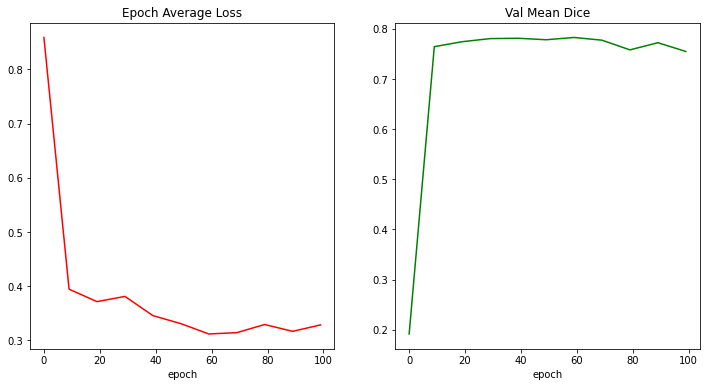

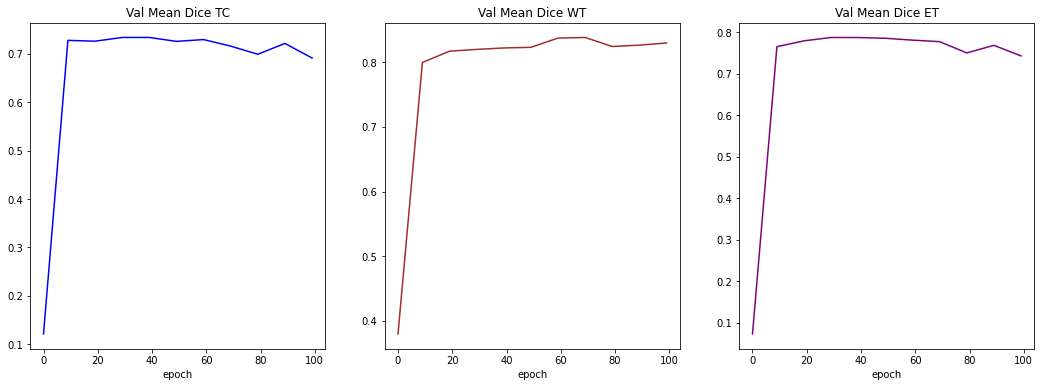

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
plt.xlabel("epoch")
plt.plot(trains_epoch, loss_epochs, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_avg, color="green")
plt.show()
plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_tc, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_wt, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
plt.xlabel("epoch")
plt.plot(trains_epoch, dices_et, color="purple")
plt.show()

## Create test set dataloader

In [ ]:
case_num = "01619"

test_files = [
    {
        "image": [
            os.path.join(
                data_dir,
                "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_flair.nii.gz",
            ),
            os.path.join(
                data_dir,
                "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t1ce.nii.gz",
            ),
            os.path.join(
                data_dir,
                "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t1.nii.gz",
            ),
            os.path.join(
                data_dir,
                "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t2.nii.gz",
            ),
        ],
        "label": os.path.join(
            data_dir,
            "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_seg.nii.gz",
        ),
    }
]

test_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

test_ds = data.Dataset(data=test_files, transform=test_transform)

test_loader = data.DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)

## Load the best saved checkpoint and perform inference

We select a single case from the validation set and perform inference to compare the model segmentation output with the corresponding label.

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "model.pt"))["state_dict"])
model.to(device)
model.eval()

model_inferer_test = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=1,
    predictor=model,
    overlap=0.6,
)


with torch.no_grad():
    for batch_data in test_loader:
        image = batch_data["image"].cuda()
        prob = torch.sigmoid(model_inferer_test(image))
        seg = prob[0].detach().cpu().numpy()
        seg = (seg > 0.5).astype(np.int8)
        seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
        seg_out[seg[1] == 1] = 2
        seg_out[seg[0] == 1] = 1
        seg_out[seg[2] == 1] = 4

## Visualize segmentation output and compare with label

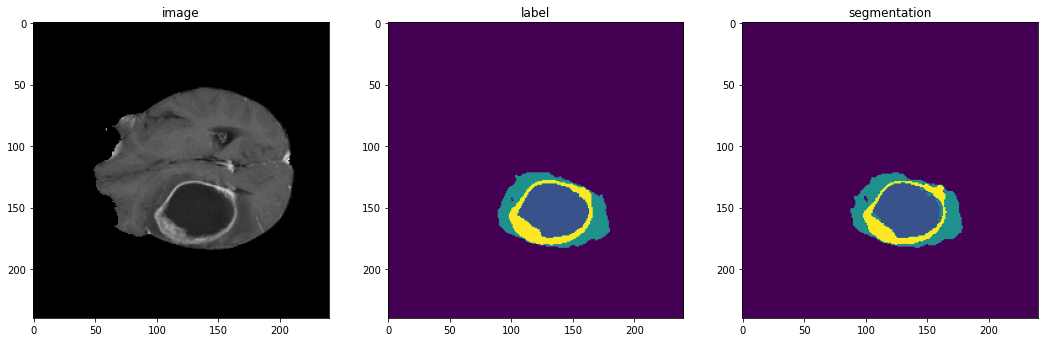

In [ ]:
slice_num = 67
img_add = os.path.join(
    data_dir,
    "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t1ce.nii.gz",
)
label_add = os.path.join(
    data_dir,
    "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_seg.nii.gz",
)
img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()
plt.figure("image", (18, 6))
plt.subplot(1, 3, 1)
plt.title("image")
plt.imshow(img[:, :, slice_num], cmap="gray")
plt.subplot(1, 3, 2)
plt.title("label")
plt.imshow(label[:, :, slice_num])
plt.subplot(1, 3, 3)
plt.title("segmentation")
plt.imshow(seg_out[:, :, slice_num])
plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)